In [22]:
import matplotlib.pyplot as plt
import config
import pandas as pd
import numpy as np
import download_files

In [26]:
df_excel = pd.read_excel(
        download_files.data_config.data_file,
        sheet_name=download_files.data_config.sheet_name,
        index_col=download_files.data_config.id_column,
    )

In [38]:


filtered_df = download_files.filter_data(df_excel, download_files.data_config)

invalid_mask = filtered_df[
    [download_files.data_config.pdf_url_column,
     download_files.data_config.secondary_pdf_url_column]
].apply(lambda row: not (
    (str(row[download_files.data_config.pdf_url_column]).startswith("http")) or
    (str(row[download_files.data_config.secondary_pdf_url_column]).startswith("http"))
), axis=1)

invalid_rows = filtered_df[invalid_mask]
invalid_rows[[download_files.data_config.pdf_url_column, download_files.data_config.secondary_pdf_url_column]]

,Pdf_URL,Report Html Address
BRnum,,
BR50044,file:///C:/Users/miller/Downloads/AA_AR2017.pdf,NaN
BR50268,www.akkok.com.tr/en/Sustainability/Documents/A...,NaN
BR51423,file:///C:/Users/Bailey/Downloads/China%20FAW%...,NaN
BR51461,file:///C:/Users/Bailey/AppData/Local/Microsof...,NaN
BR51521,file:///C:/Users/Yao/Downloads/201706301750592...,NaN
...,...,...
BR69689,NaN,15
BR69788,NaN,26
BR70187,NaN,259


In [2]:
def unroll_json(df: pd.DataFrame) -> pd.DataFrame:
    df = pd.DataFrame.from_dict(df["download_status"].to_dict())
    df_stacked = df.stack().reset_index()
    df_stacked.columns = ["id", "run", "values"]
    df_expanded = pd.DataFrame(df_stacked["values"].tolist(), columns=["success", "status_code", "url"])

    # Step 3: combine with index columns
    df_final = pd.concat([df_stacked[["id", "run"]], df_expanded], axis=1)
    return df_final

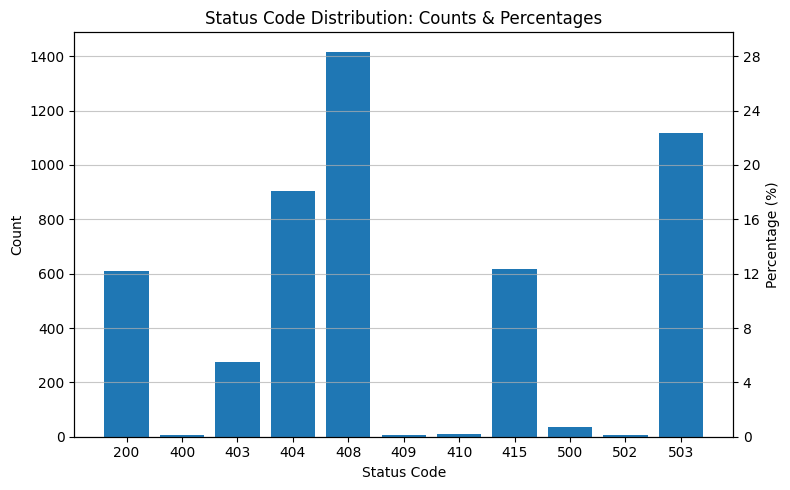

In [3]:
df_vectorized = pd.read_json("benchmarks/benchmarks_pandas_vectorization.json", orient="index")
df = unroll_json(df_vectorized)

df.columns = ["id", "run", "success", "status code", "url"]
counts = df["status code"].value_counts().sort_index()
percentages = counts / counts.sum() * 100
total = counts.sum()

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot counts on the left y-axis
bars = ax1.bar(counts.index.astype(str), counts, label='Counts')
ax1.set_xlabel("Status Code")
ax1.set_ylabel("Count")
#ax1.set_yticks(np.linspace(0, 1400, 6))
ax1.tick_params(axis='y')

# Create a second y-axis for percentages
ax2 = ax1.twinx()
# Match axis limits (scaled to 100%)
ax2.set_ylim([y / total * 100 for y in ax1.get_ylim()])

ax2.set_yticks([y / total * 100 for y in np.linspace(0, 1400, 8)])
ax2.set_ylabel("Percentage (%)")
ax2.tick_params(axis='y')

# Optional: add grid and title
ax1.set_title("Status Code Distribution: Counts & Percentages")
ax1.grid(axis='y', alpha=0.7)


plt.tight_layout()
plt.show()

In [15]:
df_sequential = pd.read_json("benchmarks/benchmarks_sequential.json", orient="index")
df_sequential_status = unroll_json(df_sequential)

df_iterrows = pd.read_json("benchmarks/benchmarks_iterrows.json", orient="index")
df_iterrows_status = unroll_json(df_iterrows)

df_vectorization = pd.read_json("benchmarks/benchmarks_pandas_vectorization.json", orient="index")
df_vectorization_status = unroll_json(df_vectorization)

means = [
    np.mean(df_sequential["elapsed_time"]),
    np.mean(df_iterrows["elapsed_time"]),
    np.mean(df_vectorization["elapsed_time"])
]

std_devs = [
    np.std(df_sequential["elapsed_time"]),
    np.std(df_iterrows["elapsed_time"]),
    np.std(df_vectorization["elapsed_time"])
]

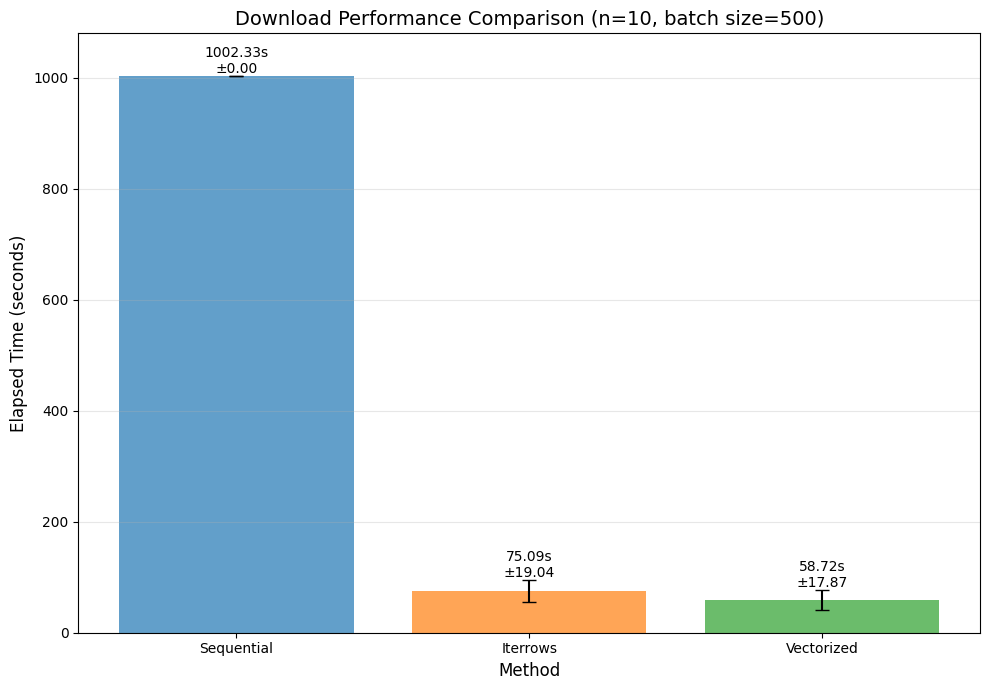

In [20]:
methods = ['Sequential', 'Iterrows', 'Vectorized']
x = np.arange(len(methods))
fig, ax = plt.subplots(figsize=(10, 7))

bars = ax.bar(x, means, yerr=std_devs, capsize=5, alpha=0.7, color=['#1f77b4', '#ff7f0e', '#2ca02c'])

ax.set_xlabel('Method', fontsize=12)
ax.set_ylabel('Elapsed Time (seconds)', fontsize=12)
ax.set_ylim(0, 1080)
ax.set_title('Download Performance Comparison (n=10, batch size=500)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (mean, std) in enumerate(zip(means, std_devs)):
    ax.text(i, mean + std, f'{mean:.2f}s\n±{std:.2f}', 
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [42]:
df_ = pd.read_json("benchmarks/benchmarks_vectorization_varying_params.json", orient="index")
df_.columns

Index(['elapsed_time', 'batch_size', 'workers', 'download_status'], dtype='object')

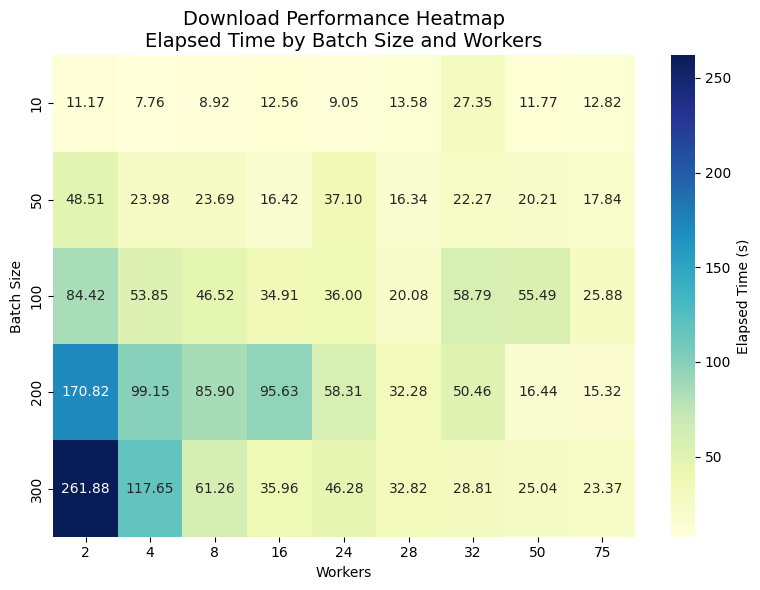

In [45]:
import seaborn as sns

pivot = df_.pivot_table(
    index="batch_size",
    columns="workers",
    values="elapsed_time",
    aggfunc="mean"   # In case you have multiple measurements
)

plt.figure(figsize=(8, 6))
sns.heatmap(
    pivot,
    annot=True, fmt=".2f", cmap="YlGnBu",
    cbar_kws={'label': 'Elapsed Time (s)'}
)

plt.title("Download Performance Heatmap\nElapsed Time by Batch Size and Workers", fontsize=14)
plt.xlabel("Workers")
plt.ylabel("Batch Size")

plt.tight_layout()
plt.show()



<Axes: title={'center': 'Normalized Time vs Workers (lower is better)'}, xlabel='workers', ylabel='normalized_time'>

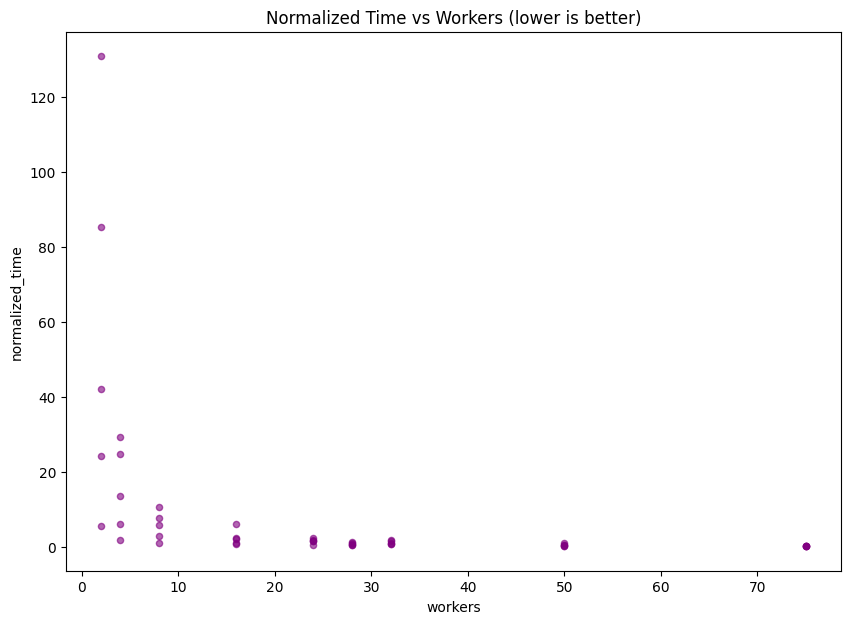

In [41]:
df_.plot(kind="scatter", x="workers", y="normalized_time", figsize=(10, 7), title="Normalized Time vs Workers (lower is better)", color='purple', alpha=0.6)